<a href="https://colab.research.google.com/github/wlail-iu/D590-NLP-F24/blob/main/Week9_Recommender_systems_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Week9:Collaborative Filtering for Movie Recommendations**



D-590 Follow Along

Aman Kumar

**References**

https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf - Neural collaborative filtering paper

https://keras.io/examples/structured_data/collaborative_filtering_movielens/

## Introduction

This example demonstrates
[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering)
using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k)
to recommend movies to users.
The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies.
Our goal is to be able to predict ratings for movies a user has not yet watched.
The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain
the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.


In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from pathlib import Path
import matplotlib.pyplot as plt

## First, load the data and apply preprocessing

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


978202/978202 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting all the files now...
Done!


In [3]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [4]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [5]:
movie2movie_encoded

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 50: 4,
 70: 5,
 101: 6,
 110: 7,
 151: 8,
 157: 9,
 163: 10,
 216: 11,
 223: 12,
 231: 13,
 235: 14,
 260: 15,
 296: 16,
 316: 17,
 333: 18,
 349: 19,
 356: 20,
 362: 21,
 367: 22,
 423: 23,
 441: 24,
 457: 25,
 480: 26,
 500: 27,
 527: 28,
 543: 29,
 552: 30,
 553: 31,
 590: 32,
 592: 33,
 593: 34,
 596: 35,
 608: 36,
 648: 37,
 661: 38,
 673: 39,
 733: 40,
 736: 41,
 780: 42,
 804: 43,
 919: 44,
 923: 45,
 940: 46,
 943: 47,
 954: 48,
 1009: 49,
 1023: 50,
 1024: 51,
 1025: 52,
 1029: 53,
 1030: 54,
 1031: 55,
 1032: 56,
 1042: 57,
 1049: 58,
 1060: 59,
 1073: 60,
 1080: 61,
 1089: 62,
 1090: 63,
 1092: 64,
 1097: 65,
 1127: 66,
 1136: 67,
 1196: 68,
 1197: 69,
 1198: 70,
 1206: 71,
 1208: 72,
 1210: 73,
 1213: 74,
 1214: 75,
 1219: 76,
 1220: 77,
 1222: 78,
 1224: 79,
 1226: 80,
 1240: 81,
 1256: 82,
 1258: 83,
 1265: 84,
 1270: 85,
 1275: 86,
 1278: 87,
 1282: 88,
 1291: 89,
 1298: 90,
 1348: 91,
 1377: 92,
 1396: 93,
 1408: 94,
 1445: 95,
 1473: 96,
 

In [6]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [7]:
df = df.sample(frac=1, random_state=42) # randomly sample the data-set
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
x_train.shape

(90752, 2)

In [9]:
y_train.shape

(90752,)

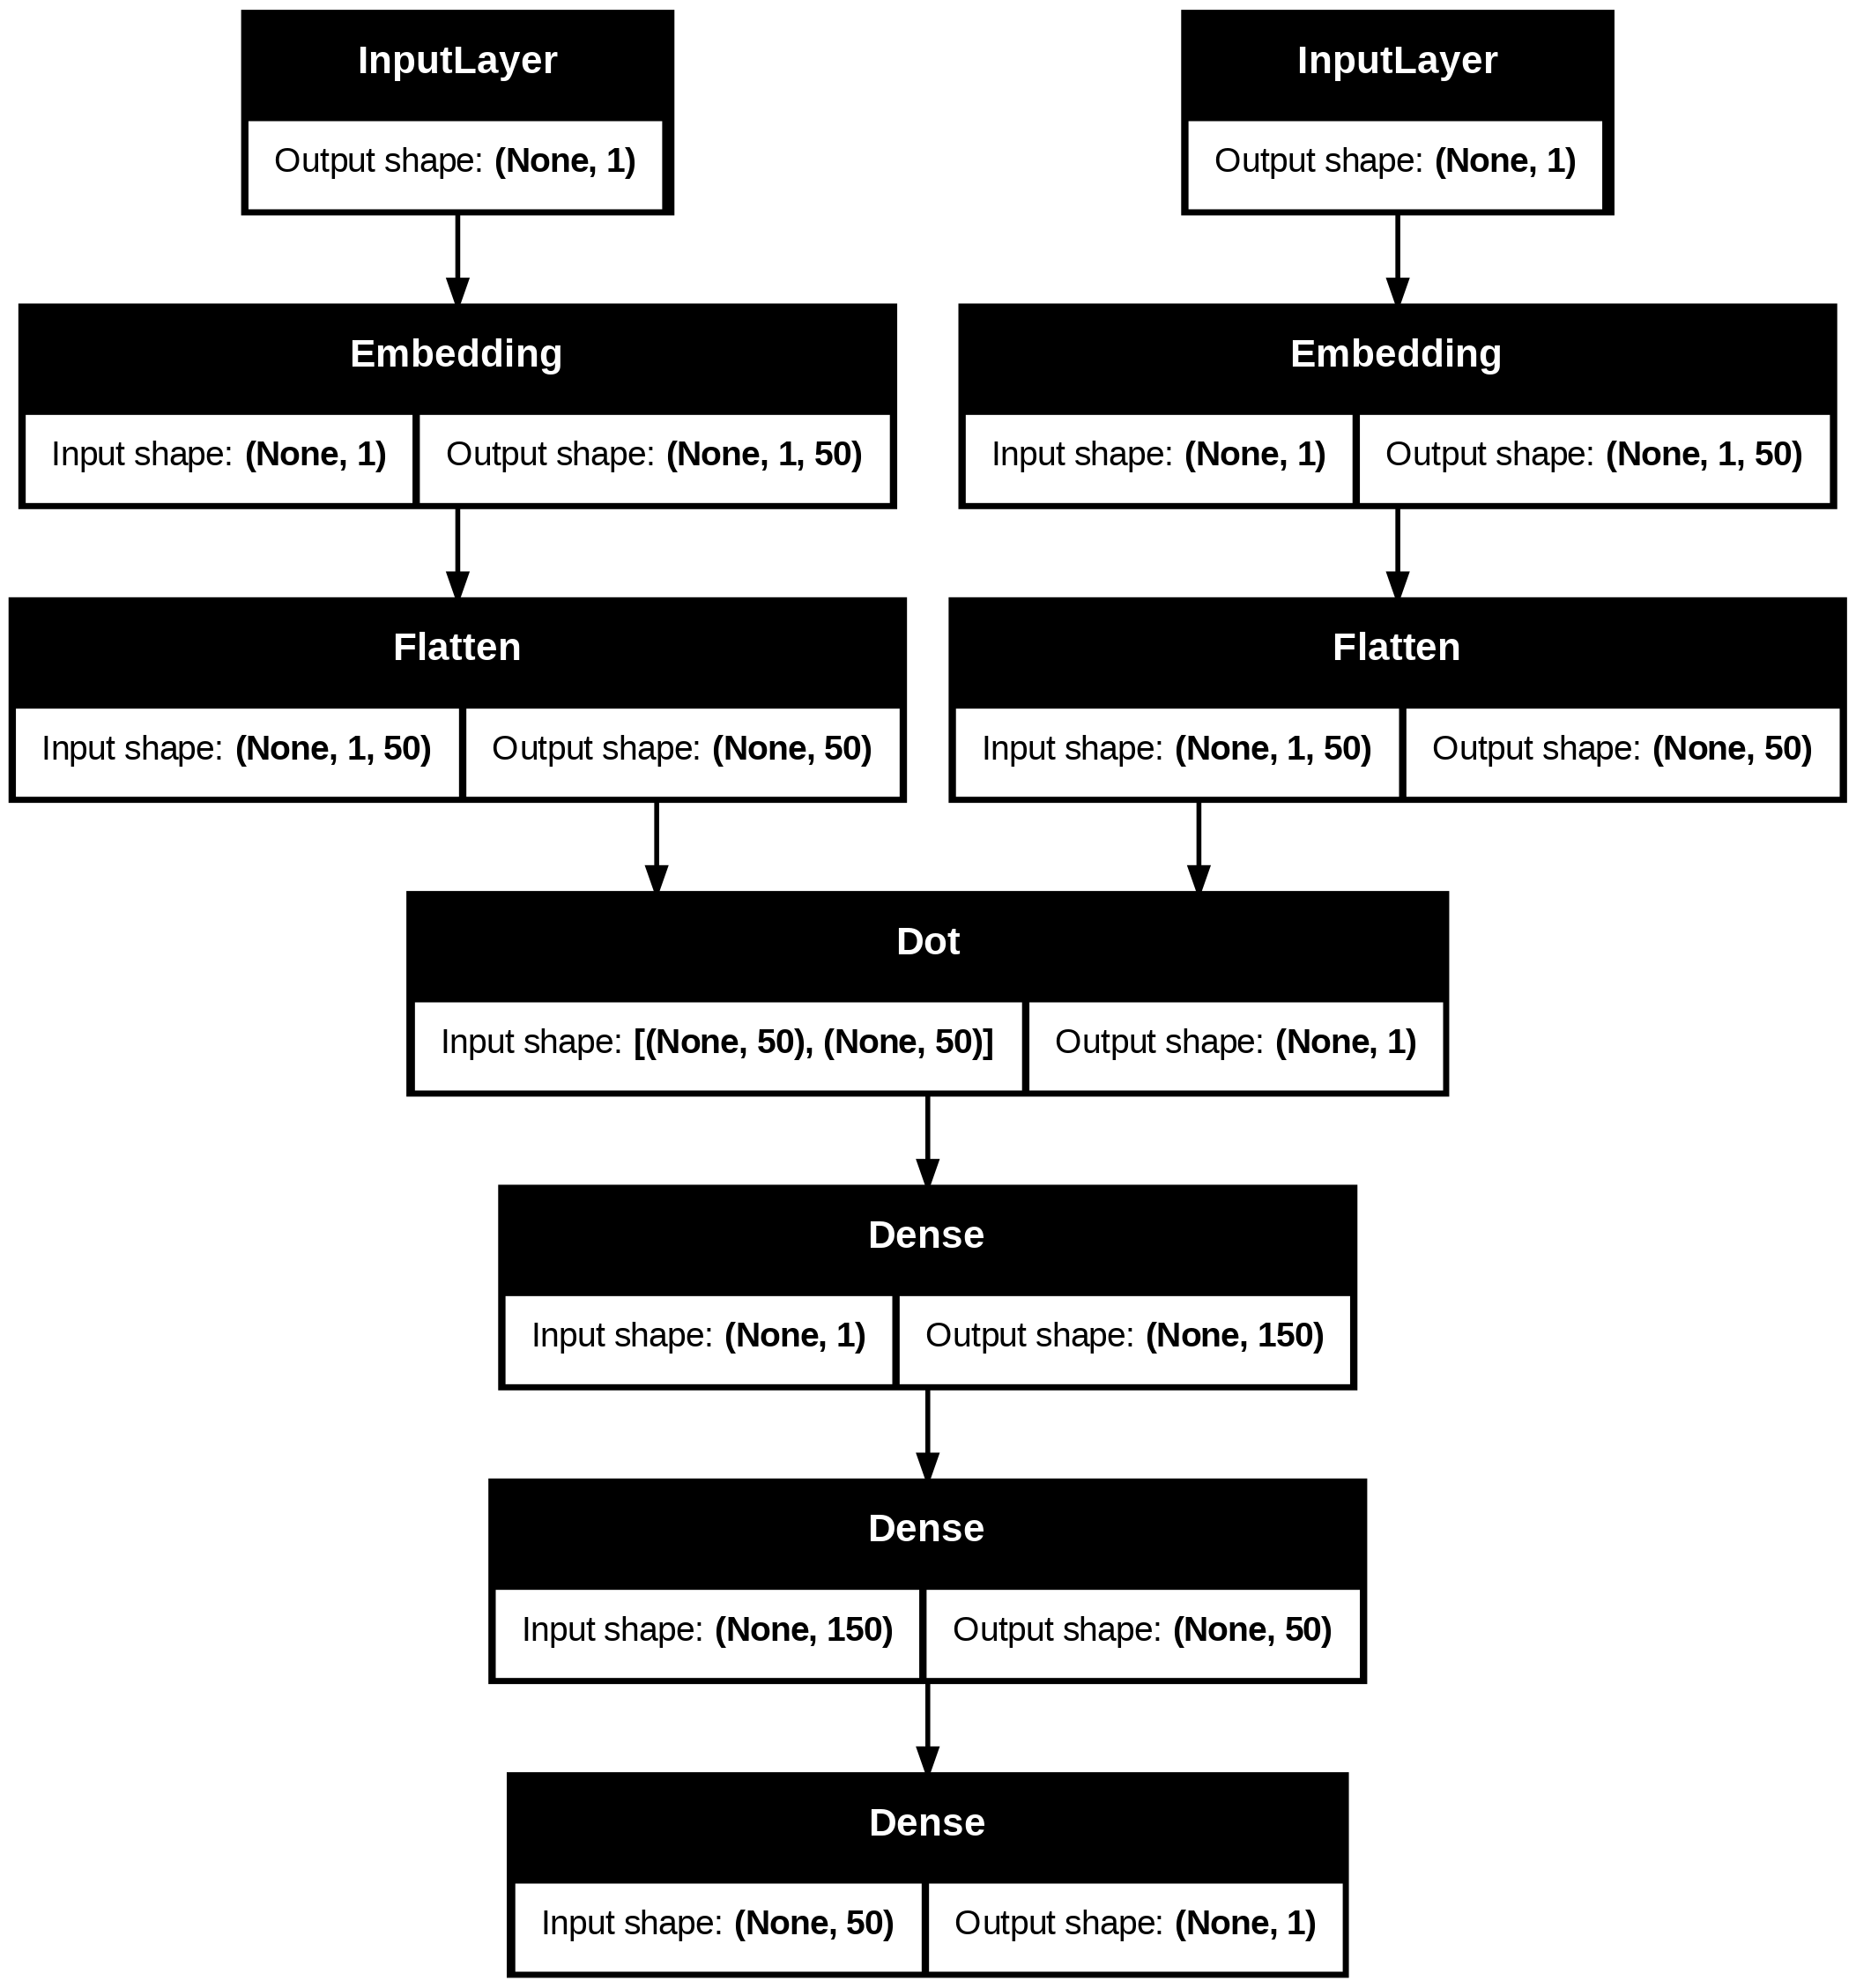

In [11]:
## defining the model
embedding_size = 50

user_ips= layers.Input(shape=[1])
user_embedding = layers.Embedding(num_users,embedding_size,embeddings_initializer="he_normal",embeddings_regularizer=keras.regularizers.l2(1e-6))(user_ips)
user_vect= layers.Flatten()(user_embedding)

movie_ips= layers.Input(shape=[1])
movie_embedding = layers.Embedding(num_movies, embedding_size, embeddings_initializer="he_normal",embeddings_regularizer=keras.regularizers.l2(1e-6))(movie_ips)
movie_vect= layers.Flatten()(movie_embedding)

prod = layers.dot(inputs=[user_vect, movie_vect],axes=1)

dense1= layers.Dense(150, activation='relu', kernel_initializer="he_normal")(prod)
dense2= layers.Dense(50, activation='relu',kernel_initializer="he_normal")(dense1)
dense3= layers.Dense(1,activation='relu')(dense2)

model = Model([user_ips, movie_ips], dense3)
model.compile(optimizer='adam',loss='mean_squared_error')

keras.utils.plot_model(model,show_shapes=True)

In [12]:
history = model.fit([x_train[:,0], x_train[:,1]], y_train, batch_size=64,epochs=10,verbose=1)

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.0737
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0446
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0332
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0292
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0239
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0227
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0202
Epoch 8/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0188
Epoch 9/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0177
Epoch 10/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0169


In [13]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict([user_movie_array[:,0],user_movie_array[:,1]]).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


272/272 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing recommendations for user: 249
Movies with high ratings from user
--------------------------------
Matrix, The (1999) : Action|Sci-Fi|Thriller
The Machinist (2004) : Drama|Mystery|Thriller
Inglourious Basterds (2009) : Action|Drama|War
Avengers, The (2012) : Action|Adventure|Sci-Fi|IMAX
Cabin in the Woods, The (2012) : Comedy|Horror|Sci-Fi|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
It's a Wonderful Life (1946) : Children|Drama|Fantasy|Romance
Patton (1970) : Drama|War
Chasing Amy (1997) : Comedy|Drama|Romance
Dark Crystal, The (1982) : Adventure|Fantasy
Patriot Games (1992) : Action|Crime|Drama|Thriller
Man Bites Dog (C'est arrivé près de chez vous) (1992) : Comedy|Crime|Drama|Thriller
Road Warrior, The (Mad Max 2) (1981) : Action|Adventure|Sci-Fi|Thriller
Love and Death (1975) : Comedy
Requiem for a Dream (2000) : Drama
Bowling for Columbine (2002) : Documentary
